# ILQR Demo For N-dim System

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacobian, jacfwd, jacrev, hessian

# Random Setup
seed = 24234156
key = random.key(seed)

# Initialization
dt = 0.01

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## 1. 2d Pendulum System Dynamics

a pendulum rotating on a vertical plane.

- kinematic energy: $E = \frac{1}{2} m v^2$
- potential energy: $P = \frac{1}{2} mgl sin\theta$

State space system $$x = [\theta \quad \dot{\theta}]^T = [x_1 \quad x_2]^T$$
then we have 
$$ \dot{x} = f(x,u) = [ x_2 \quad -\frac{l}{g} \cos{x_1} + \frac{1}{ml} u ]^T $$



## 2. iLQR Implementation from Scratch

In [12]:
def f(x, u):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.5 # m
    
    x1, x2 = x
    dx1 = x2
    dx2 = - (l / g) * jnp.cos(x1) + (1 / (m * l)) * u # (u**2)

    # x1, x2 = x
    # dx1 = x2
    # dx2 = u

    return jnp.array([dx1, dx2])

In [13]:
x = np.array([2,0.6])
x1, x2 = x
print(x1)
print(x2)
u = 1
f(x,u)

2.0
0.6


Array([0.6     , 1.021232], dtype=float32)

In [14]:
def fd_rk4(x, u):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.5 # m

    s1 = f(x,u)
    s2 = f( x+ dt/2*s1, u )
    s3 = f( x+ dt/2*s2, u )
    s4 = f( x+ dt*s3, u )
    x_next = x + dt/6 * ( s1 + 2 * s2 + 2 * s3 + s4 )
    
    return x_next

In [19]:
fd_rk4_x = jacfwd(fd_rk4, argnums=0)
fd_rk4_u = jacfwd(fd_rk4, argnums=1)
fd_rk4_xx = hessian(fd_rk4)

x = random.normal(key, (2,))
u = random.normal(key, ())

print(x)
print(u)

print("f wrt x is ",fd_rk4_x(x,u))
print("f wrt u is ",fd_rk4_u(x,u))

print("f wrt xx is ",fd_rk4_xx(x,u))

[0.49798056 0.09021932]
1.003158
f wrt x is  [[1.00000119e+00 1.00000035e-02]
 [2.43909642e-04 1.00000119e+00]]
f wrt u is  [0.00010032 0.02006317]
f wrt xx is  [[[2.2408215e-06 7.4687749e-09]
  [7.4687740e-09 3.7343864e-11]]

 [[4.4812594e-04 2.2404361e-06]
  [2.2404361e-06 1.4935575e-08]]]


In [31]:
fd_rk4_xx = jacfwd(jacfwd(fd_rk4))
# fd_rk4_xx_grad = jacfwd(grad(fd_rk4)) # Gradient only defined for scalar-output functions
fd_rk4_xx_hessian = hessian(fd_rk4)

fd_rk4_uu = jacfwd(jacfwd(fd_rk4,argnums=1),argnums=1)
fd_rk4_uu_hessian = hessian(fd_rk4,argnums=1)

fd_rk4_ux = jacfwd(jacfwd(fd_rk4,argnums=1))
fd_rk4_ux_hessian = hessian(fd_rk4, argnums=[0,1])

x = random.normal(key, (2,))
u = random.normal(key, ())

print("f wrt xx is ",fd_rk4_xx(x,u))
# print("f wrt xx is grad",fd_rk4_xx_grad(x,u))
print("f wrt xx is hessian",fd_rk4_xx_hessian(x,u))

print("f wrt uu is ",fd_rk4_uu(x,u))
print("f wrt uu is hessian",fd_rk4_uu_hessian(x,u))

print("f wrt ux is ",fd_rk4_ux(x,u))
print("f wrt ux is hessian",fd_rk4_ux_hessian(x,u))

f wrt xx is  [[[2.2408215e-06 7.4687749e-09]
  [7.4687749e-09 3.7343861e-11]]

 [[4.4812591e-04 2.2404358e-06]
  [2.2404361e-06 1.4935575e-08]]]
f wrt xx is hessian [[[2.2408215e-06 7.4687749e-09]
  [7.4687740e-09 3.7343864e-11]]

 [[4.4812594e-04 2.2404361e-06]
  [2.2404361e-06 1.4935575e-08]]]
f wrt uu is  [0.0001     0.02000001]
f wrt uu is hessian [0.0001     0.02000001]
f wrt ux is  [[3.7461565e-11 1.8730772e-13]
 [1.4982692e-08 1.1236529e-10]]
f wrt ux is hessian ((Array([[[2.2408215e-06, 7.4687749e-09],
        [7.4687740e-09, 3.7343864e-11]],

       [[4.4812594e-04, 2.2404361e-06],
        [2.2404361e-06, 1.4935575e-08]]], dtype=float32), Array([[3.74615720e-11, 1.87307730e-13],
       [1.49826960e-08, 1.12365305e-10]], dtype=float32)), (Array([[3.7461569e-11, 1.8730774e-13],
       [1.4982696e-08, 1.1236530e-10]], dtype=float32), Array([0.0001    , 0.02000001], dtype=float32)))


In [16]:
fd_rk4_uu = hessian(fd_rk4, argnums=1)
x = random.normal(key, (2,))
u = random.normal(key, ())
print("f wrt uu is ",fd_rk4_uu(x,u))

f wrt uu is  [0.0001     0.02000001]


In [9]:
def fd_euler(x, u):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.5 # m

    x_next = x + dt * f(x,u)
    
    return x_next

In [64]:
def forward_pass(x_nor, x0, u):
    # x = jnp.zeros(T+1)  
    # du = jnp.zeros(T)

    x = np.zeros((T+1,nx))  
    du = np.zeros(T)
   
    x[0] = x0
    
    for t in range(T):
        du[t] = k[t] + K[t] @ (x[t] - x_nor[t])
        # u[t] += du[t]
        u = u.at[t].set(u[t]+du[t])

        # linear rollout
        # A = 1
        # B = 1
        # x[t+1] = x_nor[t+1] + A * (x[t] - x_nor[t]) + B * du[t]

        # nonlinear rollout: RK4
        x[t+1] = fd_rk4(x[t], u[t])

        # nonlinear rollout: euler
        # x[t+1] = fd_euler(x_nor[t], u[t])
        
    return x, u

In [65]:
def cost(x, u, x_target, Q, R):
    J = 0
    for t in range(T+1):
        J += 0.5 * (x[t] - x_target) @ Q @ (x[t] - x_target) + 0.5 * u[t] * R * u[t]
        print("difference of x is ", x[t] - x_target)
    return J

In [66]:
Q = jnp.array( [[1,2],[1,2]]  )
x_t = jnp.array( [1,2] )

x = random.normal(key, (2,))
u = random.normal(key, ())

print(x)
print(u)

print("f wrt x is ",fd_rk4_x(x,u))
print("f wrt u is ",fd_rk4_u(x,u))

A_t = fd_rk4_x(x,u)

A_t.T @ Q 

# State deviation weight
# R = 1  # Control effort weight

[0.49798056 0.09021932]
1.003158
f wrt x is  [[1.00000119e+00 1.00000035e-02]
 [2.43909584e-04 1.00000119e+00]]
f wrt u is  [5.00000097e-05 1.00000035e-02]


Array([[1.0002451, 2.0004902],
       [1.0100012, 2.0200024]], dtype=float32)

In [67]:
def backward_pass(x, u, x_target, Q, R):
    # Vx = jnp.zeros(T+1)
    # Vxx = jnp.zeros(T+1)
    # k = jnp.zeros(T)
    # K = jnp.zeros(T)
    

    Vx = np.zeros((T+1,nx))
    Vxx = np.zeros((T+1,nx,nx))
    k = np.zeros(T)
    K = np.zeros((T,nx))

    # Final cost-to-go
    Vx[T] = Q @ ( x[T] - x_target )
    # print("Vx[T] is ", Vx[T])
    Vxx[T] = Q

    # print("In Backward Pass")
    # print("x is", x)
    # print("u is", u)
    
    for t in reversed(range(T)):
        A = fd_rk4_x(x[t], u[t])
        # print("A is ", A)
        B = fd_rk4_u(x[t], u[t])
        # print("B is ", B)
        
        Qx = Q @ ( x[t] - x_target )  + A.T @ Vx[t+1]
        # print("Qx is ", Qx)
        Qu = R * u[t] + B.T @ Vx[t+1]
        # print("Qu is ", Qu)
        
        Qxx = Q + A.T @ Vxx[t+1] @ A
        # print("Qxx is ", Qxx)
        Qux = B.T @ Vxx[t+1] @ A
        # print("Qux is ", Qux)
        Quu = R + B @ Vxx[t+1] @ B
        # print("Quu is ", Quu)
        
        # k[t] = - jnp.linalg.inv(Quu) @ Qu 
        # K[t] = - jnp.linalg.inv(Quu) @ Qux

        k[t] = - Qu / Quu
        K[t] = - Qux / Quu
        
        # Vxx[t] = Qxx + Qux / Quu * Qux
        # Vx[t] = Qx - Qux / Quu * Qu

        Vxx[t] = Qxx + Qux * K[t]
        Vx[t] = Qx + Qux * k[t]
        
    return k, K

In [15]:
# a = jnp.array([[2,3],[1,3]])
# jnp.linalg.inv(a)

In [68]:
# Initialization

nx = 2
T = 10  # Number of time steps
x0 = jnp.array([jnp.pi/2+0.01,0])   # Initial position
x_target = jnp.array([jnp.pi/2,0])  # Target position

Q = jnp.diag( jnp.array([1000,50]) )  # State deviation weight
R = 1  # Control effort weight

x = jnp.zeros((T+1,nx))
u = jnp.zeros(T)
J_list = jnp.zeros(0)

J = cost(x, u, x_target, Q, R)
J_list = jnp.append(J_list, J)
J_prev = 0

tol = 1e-5
iter = 0
maxiter = 3e4

# Main iLQR loop

while (abs(J - J_prev) >  tol) and ( iter <  maxiter ) :  # Number of iterations    

    J_prev = J
    
    k, K = backward_pass(x, u, x_target, Q, R)
    
    x, u = forward_pass(x, x0, u)

    J = cost(x, u, x_target, Q, R)
    J_list = jnp.append(J_list, J)

    iter += 1

# Print final trajectories
print("Final state trajectory:", x)
print("Final control inputs:", u)
print("Cost evoluation:", J_list)


difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [-1.5707964  0.       ]
difference of x is  [0.00999999 0.        ]
difference of x is  [ 0.0099901 -0.0019884]
difference of x is  [ 0.00996196 -0.00364325]
difference of x is  [ 0.0099194  -0.00487674]
difference of x is  [ 0.0098666  -0.00569256]
difference of x is  [ 0.00980735 -0.00615533]
difference of x is  [ 0.00974476 -0.00636015]
difference of x is  [ 0.00968099 -0.00640629]
difference of x is  [ 0.00961709 -0.00637765]
difference of x is  [ 0.00955355 -0.00633207]
difference of x is  [ 0.00949037 -0.00630044]
difference of 

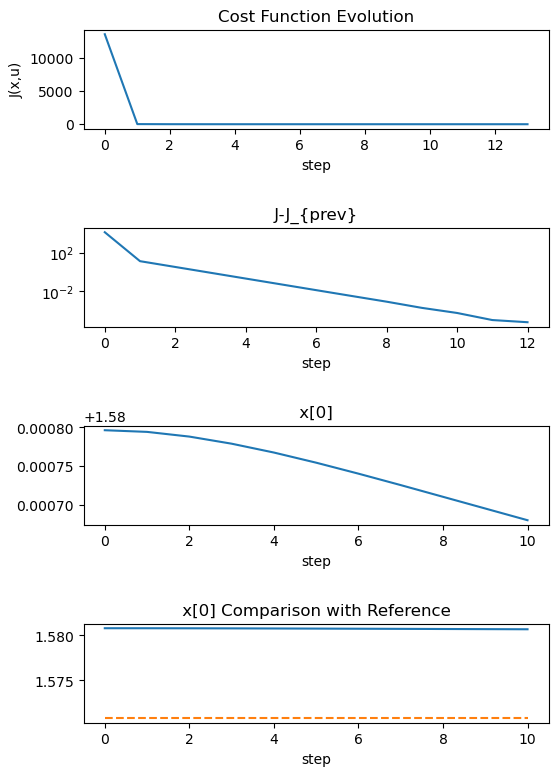

In [57]:
fig, ax = plt.subplots(4,1, figsize=(6, 9))
ax[0].plot(J_list)
ax[0].set_ylabel('J(x,u)')
ax[0].set_xlabel('step')
ax[0].set_title('Cost Function Evolution')

ax[1].plot(abs(J_list[1:]-J_list[:-1]))
ax[1].set_xlabel('step')
ax[1].set_title(' J-J_{prev} ')
ax[1].set_yscale('log')

ax[2].plot(x[:,0])
ax[2].set_xlabel('step')
ax[2].set_title(' x[0] ')

ax[3].plot(x[:,0])
ax[3].plot(np.ones_like(x[:,1]) * x_target[0], linestyle="--")
ax[3].set_xlabel('step')
ax[3].set_title(' x[0] Comparison with Reference ')

fig.subplots_adjust(hspace=1)
plt.show()

In [63]:
x0 - x_target

Array([0.00999999, 0.        ], dtype=float32)

## 3. Implementation based on Trajax